In [66]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error 
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split



In [67]:
df=pd.read_csv("dataset.csv")
df.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [68]:
df.shape

(3454, 15)

In [69]:
df.columns

Index(['device_brand', 'os', 'screen_size', '4g', '5g', 'rear_camera_mp',
       'front_camera_mp', 'internal_memory', 'ram', 'battery', 'weight',
       'release_year', 'days_used', 'normalized_used_price',
       'normalized_new_price'],
      dtype='object')

In [70]:
df.device_brand.value_counts()

device_brand
Others        502
Samsung       341
Huawei        251
LG            201
Lenovo        171
ZTE           140
Xiaomi        132
Oppo          129
Asus          122
Alcatel       121
Micromax      117
Vivo          117
Honor         116
HTC           110
Nokia         106
Motorola      106
Sony           86
Meizu          62
Gionee         56
Acer           51
XOLO           49
Panasonic      47
Realme         41
Apple          39
Lava           36
Celkon         33
Spice          30
Karbonn        29
BlackBerry     22
OnePlus        22
Microsoft      22
Coolpad        22
Google         15
Infinix        10
Name: count, dtype: int64

In [71]:
df.isnull().sum()
df.duplicated().sum()

np.int64(0)

In [72]:
df.os.value_counts()

os
Android    3214
Others      137
Windows      67
iOS          36
Name: count, dtype: int64

In [73]:
# Replace 'Windows' with 'Others' in OS column
df['os'] = df['os'].replace('Windows', 'Others')


In [74]:
df.os.value_counts()

os
Android    3214
Others      204
iOS          36
Name: count, dtype: int64

In [75]:
# Count occurrences
brand_counts = df['device_brand'].value_counts()

# Brands with >=50 occurrences
brands_to_keep = set(brand_counts[brand_counts >= 50].index)

# Always keep 'Realme' and 'Apple'
brands_to_keep.update(['Realme', 'Apple'])

# Replace less frequent brands with 'Others'
df['device_brand'] = df['device_brand'].apply(lambda x: x if x in brands_to_keep else 'Others')



In [76]:
df.device_brand.value_counts()

device_brand
Others      839
Samsung     341
Huawei      251
LG          201
Lenovo      171
ZTE         140
Xiaomi      132
Oppo        129
Asus        122
Alcatel     121
Micromax    117
Vivo        117
Honor       116
HTC         110
Nokia       106
Motorola    106
Sony         86
Meizu        62
Gionee       56
Acer         51
Realme       41
Apple        39
Name: count, dtype: int64

In [120]:
df.sample(1)

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
3446,Apple,iOS,12.9,yes,no,8.0,7.0,64,4,3046.0,188.0,2019,351,5.236616,6.713746


# EDA


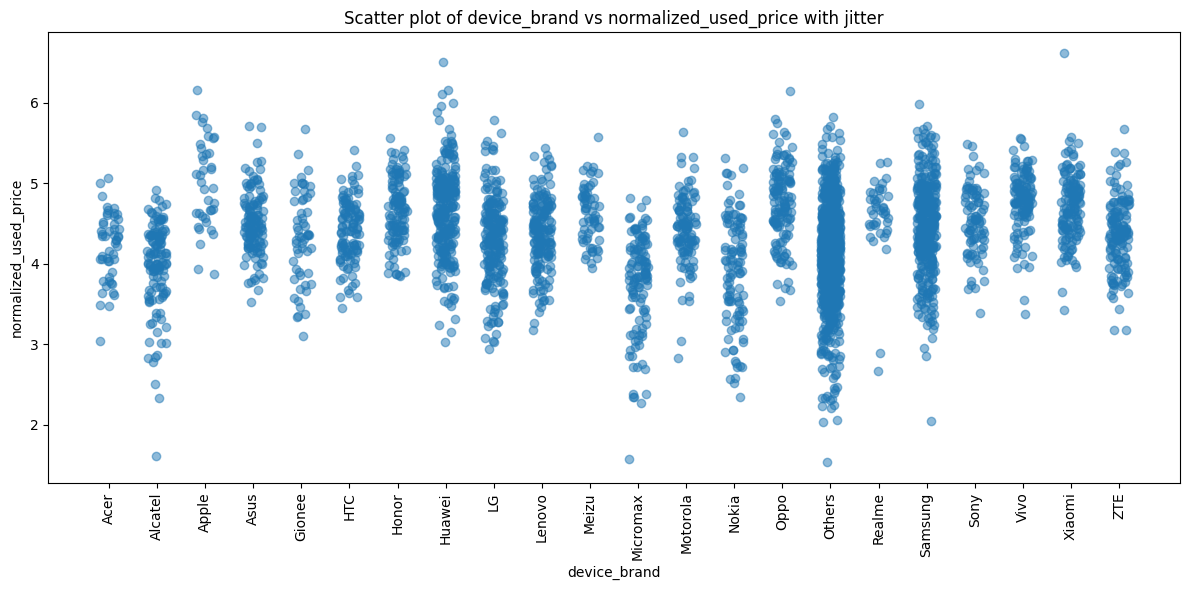

In [77]:
# Add jitter to categorical x-axis
brands = df.device_brand.astype('category').cat.codes
jitter = np.random.uniform(-0.2, 0.2, size=len(brands))
plt.figure(figsize=(12,6))
plt.scatter(brands + jitter, df.normalized_used_price, alpha=0.5)
plt.xticks(ticks=np.unique(brands), labels=df.device_brand.astype('category').cat.categories, rotation=90)
plt.xlabel('device_brand')
plt.ylabel('normalized_used_price')
plt.title('Scatter plot of device_brand vs normalized_used_price with jitter')
plt.tight_layout()
plt.show()

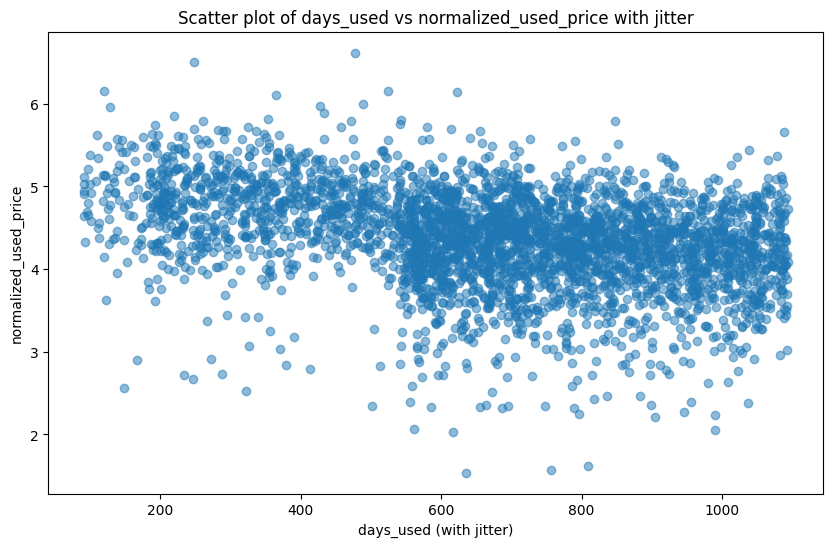

In [78]:
plt.figure(figsize=(10,6))
plt.scatter(df.days_used + jitter, df.normalized_used_price, alpha=0.5)
plt.xlabel('days_used (with jitter)')
plt.ylabel('normalized_used_price')
plt.title('Scatter plot of days_used vs normalized_used_price with jitter')
plt.show()

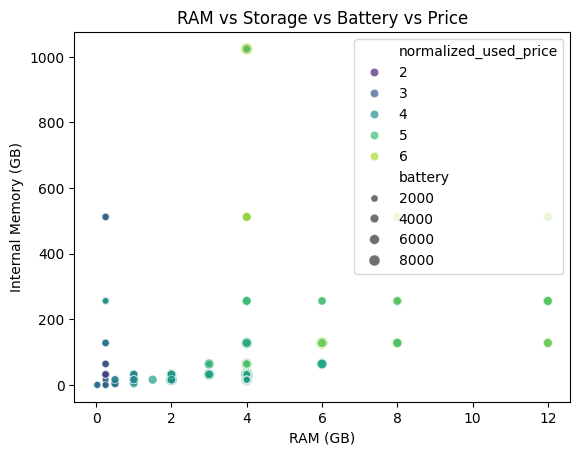

In [79]:
sns.scatterplot(x='ram', y='internal_memory', size='battery', hue='normalized_used_price', 
                data=df, palette='viridis', alpha=0.7)
plt.title("RAM vs Storage vs Battery vs Price")
plt.xlabel("RAM (GB)")
plt.ylabel("Internal Memory (GB)")
plt.show()

In [80]:
df.sample(5)

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
1153,Others,Android,17.78,no,no,5.0,0.3,32.0,4.0,4000.0,340.2,2013,621,4.399007,4.692173
3074,ZTE,Android,12.88,yes,no,14.5,8.0,32.0,4.0,3100.0,140.0,2018,373,4.481419,5.006226
1250,HTC,Android,10.24,yes,no,5.0,1.6,16.0,4.0,2000.0,123.9,2013,836,4.244200,5.305591
1329,Huawei,Android,12.70,yes,no,12.0,8.0,32.0,4.0,3020.0,146.0,2016,728,4.599554,5.706213
2190,Oppo,Android,12.70,yes,no,13.0,13.0,16.0,4.0,2140.0,150.0,2014,835,4.522658,5.799941


In [81]:
df.os.value_counts()

os
Android    3214
Others      204
iOS          36
Name: count, dtype: int64

In [82]:
df.describe()

,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
count,3454.000000,3275.000000,3452.000000,3450.000000,3450.000000,3448.000000,3447.000000,3454.000000,3454.000000,3454.000000,3454.000000
mean,13.713115,9.460208,6.554229,54.573099,4.036122,3133.402697,182.751871,2015.965258,674.869716,4.364712,5.233107
std,3.805280,4.815461,6.970372,84.972371,1.365105,1299.682844,88.413228,2.298455,248.580166,0.588914,0.683637
min,5.080000,0.080000,0.000000,0.010000,0.020000,500.000000,69.000000,2013.000000,91.000000,1.536867,2.901422
25%,12.700000,5.000000,2.000000,16.000000,4.000000,2100.000000,142.000000,2014.000000,533.500000,4.033931,4.790342
50%,12.830000,8.000000,5.000000,32.000000,4.000000,3000.000000,160.000000,2015.500000,690.500000,4.405133,5.245892
75%,15.340000,13.000000,8.000000,64.000000,4.000000,4000.000000,185.000000,2018.000000,868.750000,4.755700,5.673718
max,30.710000,48.000000,32.000000,1024.000000,12.000000,9720.000000,855.000000,2020.000000,1094.000000,6.619433,7.847841


In [83]:
df.isnull().sum()

device_brand               0
os                         0
screen_size                0
4g                         0
5g                         0
rear_camera_mp           179
front_camera_mp            2
internal_memory            4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
dtype: int64

In [84]:
df.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [85]:
df['ram'].value_counts()

ram
4.00     2815
6.00      154
8.00      130
2.00       90
0.25       83
3.00       81
1.00       34
12.00      18
0.02       18
0.03       17
0.50        9
1.50        1
Name: count, dtype: int64

In [86]:
# Example RAM values
valid_ram = np.array([1, 2, 3, 4, 6, 8, 12])

# Function to map to nearest valid RAM
def map_ram(x):
    return valid_ram[np.argmin(np.abs(valid_ram - x))]

# Apply to your dataset
df['ram'] = df['ram'].apply(map_ram)

In [87]:
df.ram.value_counts()

ram
4     2815
1      166
6      154
8      130
2       90
3       81
12      18
Name: count, dtype: int64

In [88]:
df.sample(5)

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
2438,Samsung,Android,17.78,yes,no,8.0,2.0,32.0,4,4000.0,289.0,2016,888,4.463837,5.014229
2503,Samsung,Android,17.78,no,no,2.0,5.0,32.0,4,3600.0,310.0,2015,583,4.508990,4.784654
3098,ZTE,Android,15.24,yes,no,13.0,5.0,64.0,4,4100.0,196.0,2016,591,4.291418,5.859218
1301,Huawei,Android,15.24,yes,no,8.0,8.0,128.0,4,4000.0,178.0,2017,839,5.139966,5.993762
1073,Gionee,Android,10.16,no,no,5.0,0.3,16.0,4,1700.0,142.9,2013,779,3.348851,4.249209


In [89]:
df.internal_memory.value_counts()

internal_memory
16.00      1283
32.00      1083
64.00       509
128.00      372
256.00       86
512.00       44
0.06         18
0.10         17
8.00         12
4.00         10
1024.00       8
0.50          4
0.20          2
24.00         1
0.01          1
Name: count, dtype: int64

In [90]:
valid_memory = [4, 8, 16, 32, 64, 128, 256, 512, 1024]

def map_memory(x):
    return min(valid_memory, key=lambda y: abs(y - x))

df['internal_memory'] = df['internal_memory'].apply(map_memory)


In [91]:
df.internal_memory.value_counts()

internal_memory
16      1284
32      1083
64       509
128      372
256       86
4         56
512       44
8         12
1024       8
Name: count, dtype: int64

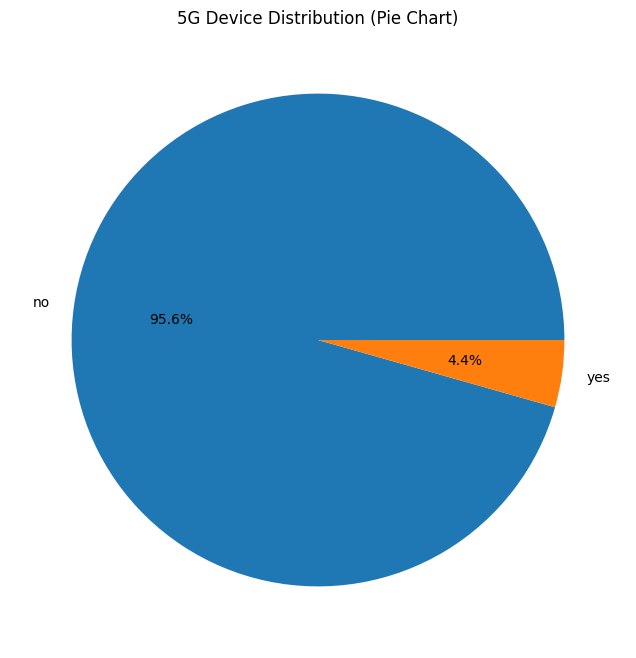

In [92]:
df['5g'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.ylabel('')
plt.title('5G Device Distribution (Pie Chart)')
plt.show()

<Axes: xlabel='count', ylabel='5g'>

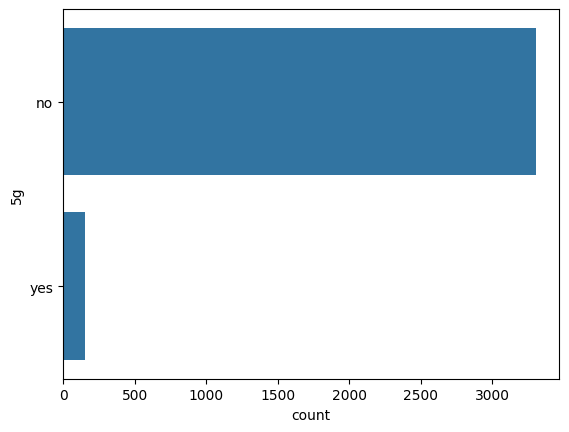

In [93]:
sns.countplot(df['5g'])

<Axes: ylabel='Frequency'>

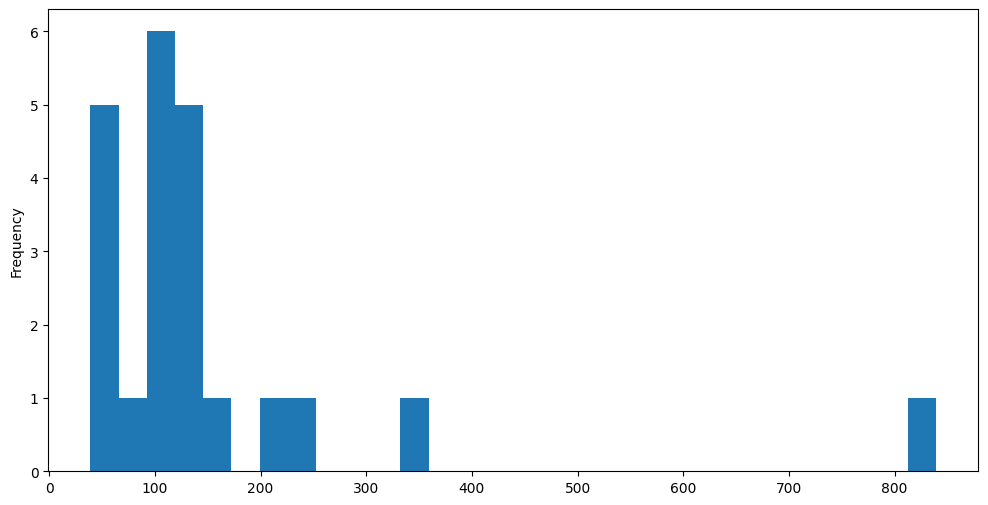

In [94]:
df['device_brand'].value_counts().plot.hist(figsize=(12,6), bins=30)

<Axes: xlabel='ram', ylabel='normalized_used_price'>

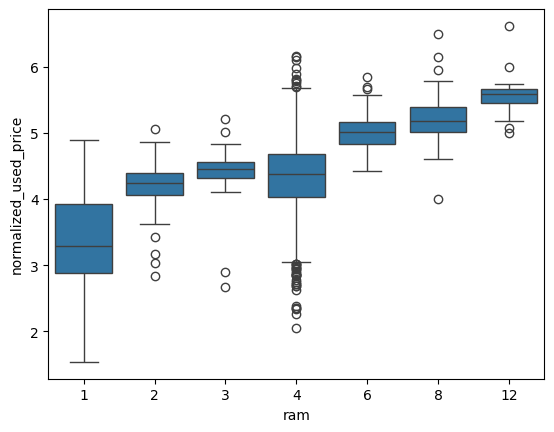

In [95]:
sns.boxplot(x='ram', y='normalized_used_price', data=df)

<Axes: xlabel='ram', ylabel='normalized_used_price'>

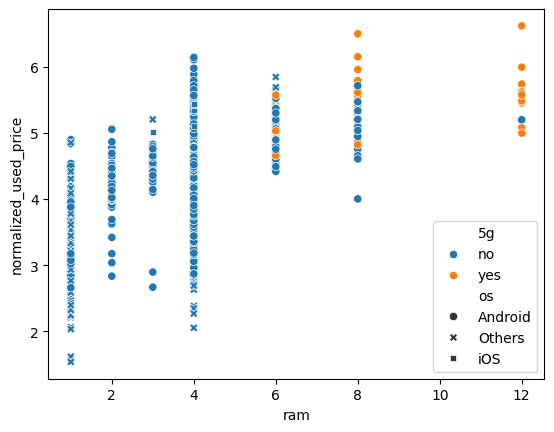

In [96]:
sns.scatterplot(x='ram',y='normalized_used_price',hue='5g',style='os',data=df)

<Axes: xlabel='os', ylabel='normalized_used_price'>

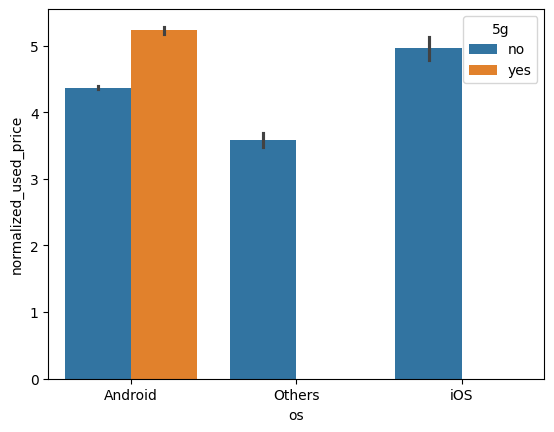

In [97]:
sns.barplot(x='os',y='normalized_used_price',hue='5g',data=df)

In [98]:
df.sample(4)

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
1047,Gionee,Android,15.24,yes,no,13.0,5.0,64,4,5020.0,208.0,2015,945,4.336899,6.039516
2602,Samsung,Android,12.88,yes,no,13.0,2.0,32,4,2800.0,154.0,2013,867,5.200208,6.522872
3270,Realme,Android,15.34,yes,no,NaN,16.0,64,4,4000.0,183.0,2019,264,4.624482,5.159974
1356,Huawei,Android,12.75,yes,no,13.0,8.0,16,4,2680.0,144.0,2015,870,4.725616,5.439470


<Axes: xlabel='days_used', ylabel='normalized_used_price'>

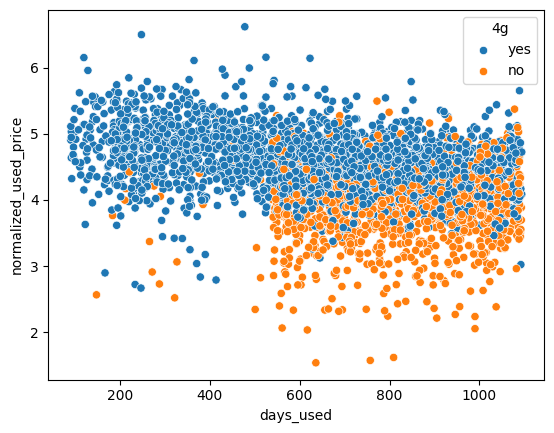

In [99]:
sns.scatterplot(x='days_used',y='normalized_used_price',hue='4g',data=df)

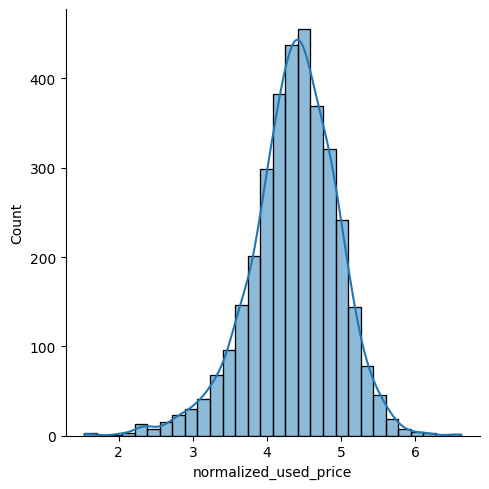

In [100]:
sns.displot(df['normalized_used_price'], kde=True, bins=30)

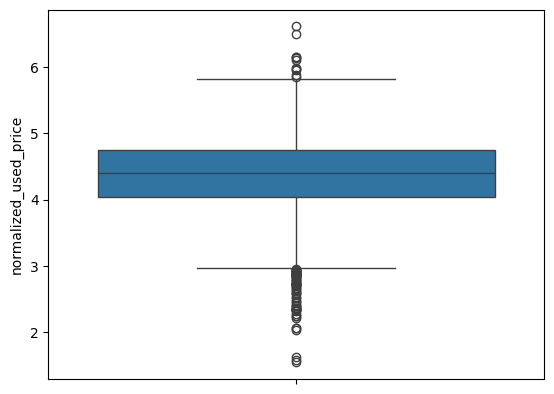

In [101]:
sns.boxplot(df['normalized_used_price'])
plt.show()


In [102]:
df['normalized_used_price'].skew()  

lower = df['normalized_used_price'].quantile(0.05)
upper = df['normalized_used_price'].quantile(0.95)

df['normalized_used_price'] = df['normalized_used_price'].clip(lower, upper)


<Axes: ylabel='normalized_used_price'>

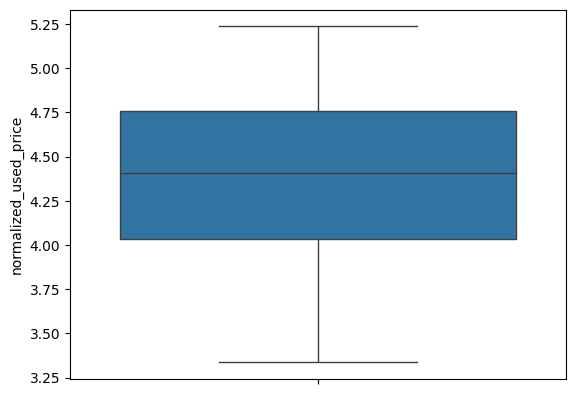

In [103]:
sns.boxplot(df['normalized_used_price'])

In [104]:
df['release_year'].dtype

dtype('int64')

In [105]:
df.describe()

,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
count,3454.000000,3275.000000,3452.000000,3454.000000,3454.000000,3448.000000,3447.000000,3454.000000,3454.000000,3454.000000,3454.000000
mean,13.713115,9.460208,6.554229,54.559351,4.061668,3133.402697,182.751871,2015.965258,674.869716,4.373027,5.233107
std,3.805280,4.815461,6.970372,84.912369,1.292661,1299.682844,88.413228,2.298455,248.580166,0.512111,0.683637
min,5.080000,0.080000,0.000000,4.000000,1.000000,500.000000,69.000000,2013.000000,91.000000,3.335414,2.901422
25%,12.700000,5.000000,2.000000,16.000000,4.000000,2100.000000,142.000000,2014.000000,533.500000,4.033931,4.790342
50%,12.830000,8.000000,5.000000,32.000000,4.000000,3000.000000,160.000000,2015.500000,690.500000,4.405133,5.245892
75%,15.340000,13.000000,8.000000,64.000000,4.000000,4000.000000,185.000000,2018.000000,868.750000,4.755700,5.673718
max,30.710000,48.000000,32.000000,1024.000000,12.000000,9720.000000,855.000000,2020.000000,1094.000000,5.236616,7.847841


In [106]:
X= df.drop(columns=['normalized_used_price'])
y= df['normalized_used_price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [107]:


from category_encoders import OrdinalEncoder, TargetEncoder


categorical_features = ['device_brand', 'os', '4g', '5g']
numerical_features = ['ram', 'internal_memory', 'battery', 'days_used','rear_camera_mp','front_camera_mp','weight','normalized_new_price']

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])  

preprocessor = ColumnTransformer(transformers=[
    ('cat_pipeline', categorical_pipeline, categorical_features),
    ('num_pipeline', numerical_pipeline, numerical_features)
])  




In [108]:


from xgboost import XGBRegressor


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred

print("model_accuracy:", model.score(X_test,y_test))
print("R2_score:", r2_score(y_test,y_pred))
print("MAE:", mean_absolute_error(y_test,y_pred))
print("MSE:", mean_squared_error(y_test,y_pred))

model_accuracy: 0.819544758772901
R2_score: 0.819544758772901
MAE: 0.17133509201599137
MSE: 0.04700446113343206


In [109]:
param_distributions = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2],
    'regressor__reg_lambda': [1, 1.5, 2],
    'regressor__reg_alpha': [0, 0.5, 1]
}

In [110]:
# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,          # number of random combinations
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train)

# Best parameters & score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# Evaluate on test set
y_pred = random_search.predict(X_test)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("\nTest Set Evaluation:")
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'regressor__subsample': 1.0, 'regressor__reg_lambda': 1.5, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 100, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.1, 'regressor__colsample_bytree': 0.8}
Best CV Score: 0.842996460514594

Test Set Evaluation:
R2: 0.857966095774906
MAE: 0.15735403287758773
MSE: 0.03699658200770217


In [111]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(random_search, X_train, y_train, cv=5, scoring='r2')
print("CV R² Scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CV R² Scores: [0.85095923 0.83810186 0.84562156 0.85315936 0.83864508]
Mean CV R²: 0.8452974145052357


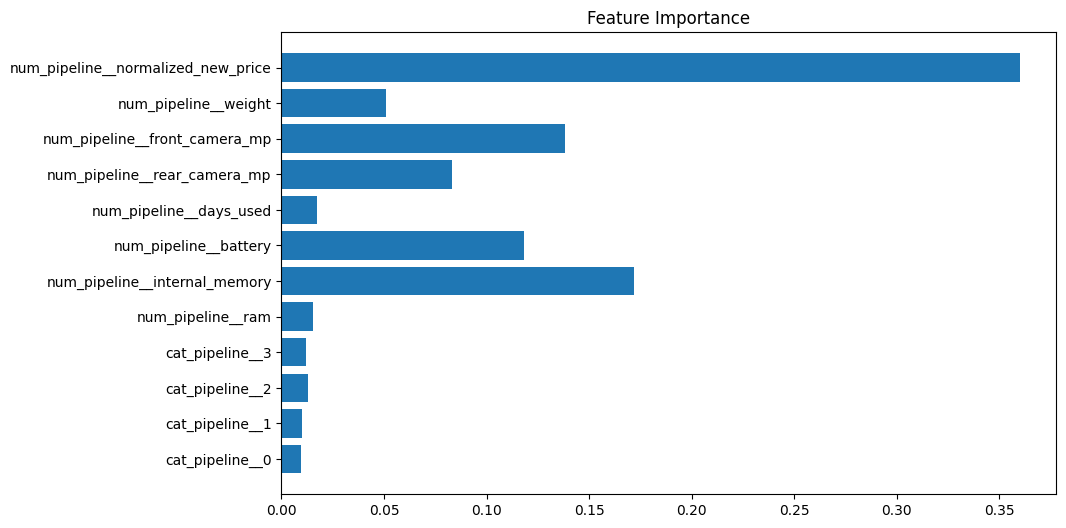

In [112]:
import matplotlib.pyplot as plt

rf = random_search.best_estimator_.named_steps['regressor']
feature_names = random_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
importances = rf.feature_importances_

plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.title("Feature Importance")
plt.show()


In [113]:
import pickle
pickle.dump(random_search,open('model.pkl','wb'))

In [114]:
X_train.columns

Index(['device_brand', 'os', 'screen_size', '4g', '5g', 'rear_camera_mp',
       'front_camera_mp', 'internal_memory', 'ram', 'battery', 'weight',
       'release_year', 'days_used', 'normalized_new_price'],
      dtype='object')

In [115]:
dodf=df[['normalized_used_price','normalized_new_price']]
dodf.to_csv('dodf.csv',index=False)

In [116]:


# Load your dataset
ndf = pd.read_csv("dodf.csv")

# Convert normalized (log) prices to actual prices
ndf["actual_used_price"] = np.exp(ndf["normalized_used_price"])
ndf["actual_new_price"] = np.exp(ndf["normalized_new_price"])

# Save to CSV
ndf.to_csv("actual_prices.csv", index=False)

print("✅ File 'actual_prices.csv' created successfully!")


✅ File 'actual_prices.csv' created successfully!


In [117]:
newdf= pd.read_csv("actual_prices.csv")
newdf.describe()

,normalized_used_price,normalized_new_price,actual_used_price,actual_new_price
count,3454.000000,3454.000000,3454.000000,3454.000000
mean,4.373027,5.233107,89.738956,237.038848
std,0.512111,0.683637,43.621564,194.302782
min,3.335414,2.901422,28.090000,18.200000
25%,4.033931,4.790342,56.482500,120.342500
50%,4.405133,5.245892,81.870000,189.785000
75%,4.755700,5.673718,116.245000,291.115000
max,5.236616,7.847841,188.032632,2560.199999


In [118]:
newdf.sample(5)

,normalized_used_price,normalized_new_price,actual_used_price,actual_new_price
2465,4.258870,5.200263,70.73,181.32
2065,3.335414,3.401197,28.09,30.00
43,4.705287,5.010969,110.53,150.05
2038,4.410493,5.795571,82.31,328.84
809,4.226542,5.561335,68.48,260.17


In [121]:
predicted_norm = 5.23  # example normalized value
actual_price = np.exp(predicted_norm)
print(f"Actual Price: {actual_price:.2f}")


Actual Price: 186.79


In [123]:
actual_new_price = 186.79  # example actual new price
normalized_new_price = np.log(actual_new_price)
print(f"Normalized New Price: {normalized_new_price:.2f}") 

Normalized New Price: 5.23
